The goal of this notebook is to explore DETER data within the first AOI i selected. group by month and make a histogram to see if DETER polygons are more clustered in dry season which would indicate they are also delayed by clouds (which might or might not be the case since they use some SAR data as well I think). Also, look at MapBiomas for the same period (and perhaps PRODES and Hansen) and visually compare them against the S-2 images.

As for PRODES v. Hansen, one compelling reason to use Hansen is that it has global coverage so then the methodology would be applicable anywhere.

In [54]:
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio
import rasterio.mask

import os

In [2]:
deter = gpd.read_file("../data/sample_data/DETER/deter_public.shp")
deter.head()

,CLASSNAME,QUADRANT,PATH_ROW,VIEW_DATE,SENSOR,SATELLITE,AREAUCKM,UC,AREAMUNKM,MUNICIPALI,GEOCODIBGE,UF,geometry
0,CS_DESORDENADO,None,177111,2021-10-02,AWFI,CBERS-4,0.0,None,2.473354,Porto Velho,1100205,RO,"POLYGON ((-65.72031 -9.55796, -65.71991 -9.557..."
1,DESMATAMENTO_CR,None,177111,2021-10-02,AWFI,CBERS-4,0.0,None,0.070332,Sena Madureira,1200500,AC,"POLYGON ((-68.85109 -9.90415, -68.85039 -9.903..."
2,DESMATAMENTO_CR,None,177111,2021-10-02,AWFI,CBERS-4,0.0,None,0.128672,Labrea,1302405,AM,"POLYGON ((-65.76534 -9.32607, -65.76502 -9.326..."
3,DESMATAMENTO_CR,None,169105,2018-01-14,AWFI,CBERS-4,0.0,None,0.101666,obidos,1505106,PA,"POLYGON ((-55.65637 -1.44008, -55.65618 -1.440..."
4,DESMATAMENTO_CR,None,169105,2018-01-14,AWFI,CBERS-4,0.0,None,0.124988,obidos,1505106,PA,"POLYGON ((-55.65314 -1.44255, -55.65314 -1.442..."


Text(0, 0.5, 'Count')

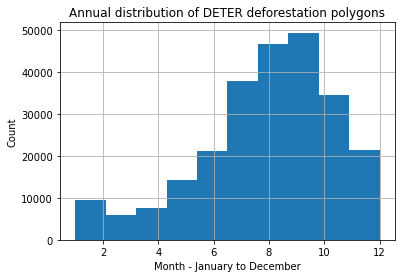

In [3]:
#deter.index = pd.to_datetime(deter.VIEW_DATE)
#deter_monthly = deter.groupby(pd.Grouper(freq='M'))
deter['month'] = pd.to_datetime(deter.VIEW_DATE).dt.month
plot = deter.month.hist()

plot.set_title("Annual distribution of DETER deforestation polygons")
plot.set_xlabel("Month - January to December")
plot.set_ylabel("Count")


[2016 2017 2018 2019 2020 2021 2022]


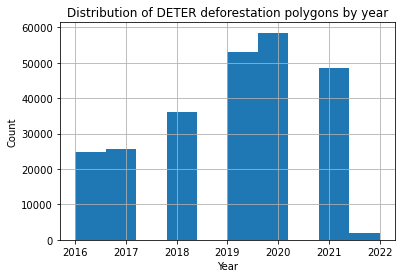

In [4]:
deter['year'] = pd.to_datetime(deter.VIEW_DATE).dt.year
plot = deter.year.hist()

plot.set_title("Distribution of DETER deforestation polygons by year")
plot.set_xlabel("Year")
plot.set_ylabel("Count")
print(np.unique(deter.year))

In [5]:
mapb = gpd.read_file("/Users/janpisl/Documents/EPFL/workdir/sample_data/MapBiomas/dashboard_alerts-shapefilePolygon.shp")
mapb.head()


mapb['month'] = pd.to_datetime(mapb.DataDetec).dt.month
plot = mapb.month.hist()
plot.set_title("Annual distribution of MapBiomas deforestation polygons")
plot.set_xlabel("Month - January to December")
plot.set_ylabel("Count")

DriverError: /Users/janpisl/Documents/EPFL/workdir/sample_data/MapBiomas/dashboard_alerts-shapefilePolygon.shp: No such file or directory

Here I clip DETER by my AOI and then extract alerts within AOI separately for July, August, September 2019.

In [6]:
aoi = gpd.read_file("../data/aoi_1/vector/aoi_1.geojson")
aoi = aoi.to_crs(deter.crs)

In [9]:
clipped_deter = gpd.clip(deter, aoi)


In [10]:
clipped_deter['date'] = pd.to_datetime(clipped_deter.VIEW_DATE)

In [8]:
clipped_deter.query('20190701 < date < 20191001').plot()

NameError: name 'clipped_deter' is not defined

[2016 2017 2018 2019 2020 2021 2022]


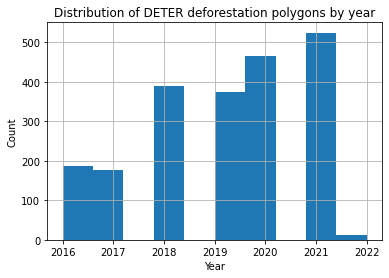

In [11]:
clipped_deter['year'] = pd.to_datetime(clipped_deter.VIEW_DATE).dt.year
plot = clipped_deter.year.hist()

plot.set_title("Distribution of DETER deforestation polygons by year")
plot.set_xlabel("Year")
plot.set_ylabel("Count")
print(np.unique(clipped_deter.year))

Here I am gonna develop the code for generating labels. The procedure for a single DETER polygon is that i buffer the polygon, then open some raster, mask and clip this by the buffered polygon and write it to disk. i will use this new raster as a template for rasterizing the polygon.

in the next step, i open the raster and burn the polygon in it

In [23]:
subset = clipped_deter[11:12]
#32722 is UTM 22S which is the right UTM zone for this area
subset = subset.to_crs(32722)

In [35]:
#deter_proj = deter.to_crs(32722)
#deter_proj['area'] = deter_proj.geometry.area
deter_proj.area.describe()


count    2.482090e+05
mean     5.457492e+05
std      2.766549e+06
min      9.736174e-04
25%      9.390980e+04
50%      1.540349e+05
75%      3.290466e+05
max      6.187093e+08
dtype: float64

In [39]:
subset

,CLASSNAME,QUADRANT,PATH_ROW,VIEW_DATE,SENSOR,SATELLITE,AREAUCKM,UC,AREAMUNKM,MUNICIPALI,GEOCODIBGE,UF,geometry,month,year,date
2075,CICATRIZ_DE_QUEIMADA,None,165105,2020-09-17,AWFI,CBERS-4,0.0,None,0.12829,Altamira,1500602,PA,"POLYGON ((214792.162 9310676.268, 214791.984 9...",9,2020,2020-09-17


<AxesSubplot:>

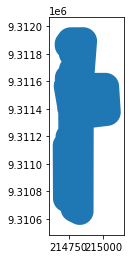

In [26]:
subset.buffer(100).plot()

'2020-09-17'

In [52]:
raster_path = '../data/aoi_1/raster/2019_2021/2019_01_02.tif'
labels_dir = '../data/aoi_1/raster/labels/'

date = subset.date.dt.strftime('%Y_%m_%d').values[0]
id = subset.PATH_ROW.values[0]
name = f"{date}_deter_{id}.tif"
out_path = os.path.join(labels_dir, name)

with rasterio.open(raster_path) as src:
    out_image, out_transform = rasterio.mask.mask(src, [subset.buffer(100).geometry.values[0]], crop=True)
    out_meta = src.meta


out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(out_path, "w", **out_meta) as dest:
    dest.write(out_image)

In [53]:
with rasterio.open(out_path) as src:
    out_image, out_transform = rasterio.mask.mask(src, [subset.geometry.values[0]])
    out_meta = src.meta
    out_image[out_image > 0] = 1


out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(out_path, "w", **out_meta) as dest:
    dest.write(out_image)